In [1]:
import numpy as np
from roguewave.wavespectra.estimators.mem2 import mem2
from roguewave.wavespectra.estimators.mem import mem
from numba_progress import ProgressBar
from typing import Literal

import os
import pickle

import pandas as pd
import wavespectra 
import xarray as xr

import matplotlib.pyplot as plt

Estimators = Literal["mem", "mem2"]


# -----------------------------------------------------------------------------
#                       Boilerplate Interfaces
# -----------------------------------------------------------------------------
def estimate_directional_spectrum_from_moments(
    e: np.ndarray,
    a1: np.ndarray,
    b1: np.ndarray,
    a2: np.ndarray,
    b2: np.ndarray,
    direction: np.ndarray,
    method: Estimators = "mem2",
    **kwargs,
) -> np.ndarray:
    """
    Construct a 2D directional distribution based on the directional moments and a spectral
    reconstruction method.

    :param number_of_directions: length of the directional vector for the
    2D spectrum. Directions returned are in degrees

    :param method: Choose a method in ['mem','mem2']
        mem: maximum entrophy (in the Boltzmann sense) method
        Lygre, A., & Krogstad, H. E. (1986). Explicit expression and
        fast but tends to create narrow spectra anderroneous secondary peaks.

        mem2: use entrophy (in the Shannon sense) to maximize. Likely
        best method see- Benoit, M. (1993).

    REFERENCES:
    Benoit, M. (1993). Practical comparative performance survey of methods
        used for estimating directional wave spectra from heave-pitch-roll data.
        In Coastal Engineering 1992 (pp. 62-75).

    Lygre, A., & Krogstad, H. E. (1986). Maximum entropy estimation of the
        directional distribution in ocean wave spectra.
        Journal of Physical Oceanography, 16(12), 2052-2060.

    """
    return (
        estimate_directional_distribution(a1, b1, a2, b2, direction, method, **kwargs)
        * e[..., None]
    )


def estimate_directional_distribution(
    a1: np.ndarray,
    b1: np.ndarray,
    a2: np.ndarray,
    b2: np.ndarray,
    direction: np.ndarray,
    method: Estimators = "mem2",
    **kwargs,
) -> np.ndarray:
    """
    Construct a 2D directional distribution based on the directional moments and a spectral
    reconstruction method.

    :param number_of_directions: length of the directional vector for the
    2D spectrum. Directions returned are in degrees

    :param method: Choose a method in ['mem','mem2']
        mem: maximum entrophy (in the Boltzmann sense) method
        Lygre, A., & Krogstad, H. E. (1986). Explicit expression and
        fast but tends to create narrow spectra anderroneous secondary peaks.

        mem2: use entrophy (in the Shannon sense) to maximize. Likely
        best method see- Benoit, M. (1993).

    REFERENCES:
    Benoit, M. (1993). Practical comparative performance survey of methods
        used for estimating directional wave spectra from heave-pitch-roll data.
        In Coastal Engineering 1992 (pp. 62-75).

    Lygre, A., & Krogstad, H. E. (1986). Maximum entropy estimation of the
        directional distribution in ocean wave spectra.
        Journal of Physical Oceanography, 16(12), 2052-2060.

    """

    # Jacobian to transform distribution as function of radian angles into
    # degrees.
    Jacobian = np.pi / 180
    direction_radians = direction * Jacobian

    if method.lower() in ["maximum_entropy_method", "mem"]:
        # reconstruct the directional distribution using the maximum entropy
        # method.
        function = mem
    elif method.lower() in ["maximum_entrophy_method2", "mem2"]:
        function = mem2
    else:
        raise Exception(f"unsupported spectral estimator method: {method}")

    output_shape = list(a1.shape) + [len(direction)]
    if a1.ndim == 1:
        input_shape = [1, a1.shape[-1]]
    else:
        input_shape = [np.prod(a1.shape[0:-1]), a1.shape[-1]]

    a1 = a1.reshape(input_shape)
    b1 = b1.reshape(input_shape)
    a2 = a2.reshape(input_shape)
    b2 = b2.reshape(input_shape)

    number_of_iterations = a1.shape[0]
    if number_of_iterations < 10:
        disable = True
    else:
        disable = False

    if method != "mem2":
        msg = f"Reconstructing 2d spectrum with {method} using implementation: "
    else:
        solution_method = kwargs.get("solution_method", "scipy")
        msg = f"Reconstructing 2d spectrum with {method} using solution_method {solution_method}"

    with ProgressBar(total=number_of_iterations, disable=disable, desc=msg) as progress:
        res = function(direction_radians, a1, b1, a2, b2, progress, **kwargs)

    return res.reshape(output_shape) * Jacobian

In [32]:
DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP/buoy_data/'
DATA_FILENAME = 'hurricane_ian_spotter_data_v1.pickle'

with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    spotter = pickle.load(handle)

# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter_ids = list(spotter.keys())
spotter_id = spotter_ids[0]

# Extract the observation times that contain spectral data.
only_waves = spotter[spotter_id]['energy_density'].notnull()
drifter = spotter[spotter_id][only_waves]

# Exract the coordinate arrays; note that the frequency array is
# uniform across the Spotter observations, so we can just 
# use the array in the first index of the DataFrame.
time = drifter.index.to_numpy()
freq = drifter['frequency'][0] 

# Extract the variable arrays.
efth = np.stack(drifter['energy_density'])
lat = drifter['latitude']
lon = drifter['longitude']

# Construct the dataset. This must match the conventions used by the
# wavespectra package:
# (https://wavespectra.readthedocs.io/en/latest/conventions.html#)
# The directional spectrum is computed using the
# directional moments and an estimator (e.g. MEM).
directions = np.arange(0., 360., 10)
efth_array = np.zeros( (len(time), len(freq), len(directions)))
for i in range(len(time)):
    print(np.sum(drifter.a1[i]))
    ea = estimate_directional_distribution( drifter.a1[i], drifter.b1[i], \
                                                     drifter.a2[i], drifter.b2[i], directions, method='mem2' )
    #print(np.shape(ea))
    efth_array[i,:,:]
    #print( np.sum(ea) )

# efth(time, freq) and not efth(time, freq, dir).
ds = xr.Dataset(
    data_vars=dict(
        efth=(["time", "freq", "dir"], efth_array), #TODO: need to compute this
        # efth=(["time", "freq"], efth), # Delete this line if using above (Note: efth may need to be transposed)
        # lat=(["time"], lat),
        # lon=(["time"], lon),
        site="",
    ),
    coords=dict(
        time=time,
        freq=freq,
        dir=directions, #TODO: need to compute this from directional moments
    ),
    attrs=dict(
        # Attributes here; wavespectra would put significant wave
        # height, etc., here but these are a function of time so it
        # might be reasonable to set them as data_vars instead (as 
        # a function of the time coordinate)
    )
)

-10.575757
-11.797655
-14.000972999999997
-16.500487
-16.01173
-16.801567
-21.28543300000001
-21.009776000000006
-22.739980000000003
-23.908112000000006
-23.649068000000007
-23.78299
-23.141742999999995
-22.589442999999996
-23.545454
-24.575756000000002
-23.584553
-24.818178999999994
-24.585531999999997
-22.722382
-23.487779999999997
-23.724339999999998
-20.784948999999997
-18.559135999999995
-20.601172999999992
-17.270771000000007
-14.317692999999998
-14.511244
-13.443791999999998
-16.405671
-14.760508
-12.451613000000002
-8.659820999999999
1.984359
11.152494
14.864125
17.763441000000004
19.327471000000003
20.669594999999997
20.906157
21.491692
19.305966000000005
21.205279
20.485828
20.422288999999996
20.569892999999993
20.015639
19.356794999999995
19.625612999999998
18.272724999999994
18.249268999999995
17.452591000000005
17.081133999999995
17.822090999999997
18.152490999999998
18.386115999999994
18.204303999999997
18.965787999999996
18.696971
18.423267
18.418378999999998
19.00684599

In [30]:
drifter.b1

time
2022-09-27 00:35:55+00:00    [-0.062561, -0.00782, 0.021505, -0.017595, 0.0...
2022-09-27 01:35:55+00:00    [0.268817, 0.230694, 0.13783, 0.020528, 0.0234...
2022-09-27 02:35:55+00:00    [0.190616, 0.031281, 0.121212, 0.074291, 0.001...
2022-09-27 03:35:55+00:00    [0.075269, 0.009775, -0.096774, 0.040078, 0.12...
2022-09-27 04:35:55+00:00    [0.056696, 0.00782, 0.022483, -0.030303, 0.011...
                                                   ...                        
2022-09-29 19:35:55+00:00    [-0.151515, -0.081134, -0.168133, -0.28348, -0...
2022-09-29 20:35:55+00:00    [-0.111437, -0.135875, -0.233627, -0.304985, -...
2022-09-29 21:35:55+00:00    [0.016618, -0.13783, -0.352884, -0.327468, -0....
2022-09-29 22:35:55+00:00    [-0.148583, -0.232649, -0.177908, -0.305963, -...
2022-09-29 23:35:55+00:00    [-0.103617, -0.212121, -0.333333, -0.256109, -...
Name: b1, Length: 72, dtype: object

In [14]:
ds

<xarray.Dataset>
Dimensions:  (time: 72, freq: 39, dir: 36)
Coordinates:
  * time     (time) object 2022-09-27T00:35:55+00:00 ... 2022-09-29T23:35:55+...
  * freq     (freq) float64 0.0293 0.03906 0.04883 ... 0.4688 0.498 0.6543
  * dir      (dir) float64 0.0 10.0 20.0 30.0 40.0 ... 320.0 330.0 340.0 350.0
Data variables:
    efth     (time, freq, dir) float64 0.001702 0.002077 ... 0.003552 0.003497
    site     <U1 ''

In [22]:
ds.efth[1].spec.hs()

<xarray.DataArray 'hs' ()>
array(3.73433796)
Coordinates:
    time     datetime64[ns] 2022-09-27T01:35:55
Attributes:
    standard_name:  sea_surface_wave_significant_height
    units:          m

In [4]:
efth_array

array([[[0.00170249, 0.00207724, 0.00259058, ..., 0.00134063,
         0.00134626, 0.00146355],
        [0.00114454, 0.0015621 , 0.00223286, ..., 0.00082467,
         0.00081441, 0.00091266],
        [0.00087438, 0.00134084, 0.00215486, ..., 0.00050592,
         0.00052063, 0.00062951],
        ...,
        [0.00119602, 0.00127299, 0.00132303, ..., 0.00079251,
         0.00094491, 0.00108474],
        [0.00117202, 0.00121972, 0.0012353 , ..., 0.00081312,
         0.00095767, 0.00108298],
        [0.00240032, 0.00217472, 0.00195406, ..., 0.00256967,
         0.00264273, 0.0025751 ]],

       [[0.00060882, 0.00080974, 0.0011946 , ..., 0.00058994,
         0.00051759, 0.00052226],
        [0.0006503 , 0.00079032, 0.00106386, ..., 0.00074489,
         0.00063332, 0.00060324],
        [0.00071081, 0.00082577, 0.00105571, ..., 0.00087211,
         0.00073372, 0.00068294],
        ...,
        [0.00090472, 0.00099292, 0.00104178, ..., 0.00049871,
         0.00063792, 0.00078064],
        [0.0

In [5]:
directions = np.arange(0., 360., 10)
efth_array = np.zeros( (len(time), len(freq), len(directions)))
print(np.shape(efth_array))

(72, 39, 36)


In [6]:
for i in range(len(time)):
   efth_array[i,:,:] = estimate_directional_distribution( drifter.a1[i], drifter.b1[i], \
                                                         drifter.a2[i], drifter.b2[i], directions, method='mem' )

In [7]:
np.shape(efth_array)
efth_array

array([[[0.00173464, 0.0020019 , 0.00241093, ..., 0.00148448,
         0.0014933 , 0.00157292],
        [0.00123232, 0.00145878, 0.00184874, ..., 0.00105992,
         0.00105374, 0.00110729],
        [0.00098326, 0.00119967, 0.00158822, ..., 0.00080193,
         0.00080824, 0.00086405],
        ...,
        [0.00093228, 0.00109816, 0.00129578, ..., 0.00061794,
         0.00069576, 0.0007991 ],
        [0.00090784, 0.00104071, 0.00119361, ..., 0.00064152,
         0.00070928, 0.00079745],
        [0.00245667, 0.00230408, 0.00213482, ..., 0.00234416,
         0.0025007 , 0.00253736]],

       [[0.0008817 , 0.00097439, 0.00114291, ..., 0.00089703,
         0.00084746, 0.00084239],
        [0.00093697, 0.00100734, 0.0011404 , ..., 0.0010028 ,
         0.0009358 , 0.00091474],
        [0.00098485, 0.00104597, 0.00116565, ..., 0.00108033,
         0.00100131, 0.00097093],
        ...,
        [0.00057661, 0.00067902, 0.00081187, ..., 0.00040206,
         0.0004426 , 0.00049944],
        [0.0

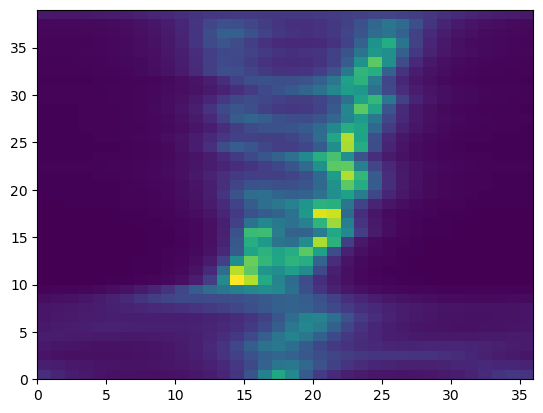

In [8]:
plt.pcolormesh(np.squeeze(efth_array[20]))